Kaggle house price prediction machine learning project


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import google.colab
import requests

In [ ]:
try:
    url = 'https://raw.githubusercontent.com/joccing/ICT303-assignment1/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_data()

Finished!


In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
raw_train = train.drop(columns=['Id', 'SalePrice'])
raw_test = test.drop(columns=['Id'])
features = pd.concat([raw_train, raw_test])

numeric_features = features.dtypes[features.dtypes != 'object'].index
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
features[numeric_features] = features[numeric_features].fillna(0)
features = pd.get_dummies(features, dummy_na=True)

new_train = features[:raw_train.shape[0]].copy()
new_train['SalePrice'] = train['SalePrice']
new_test = features[raw_train.shape[0]:].copy()

X_train = torch.tensor(new_train.drop(columns=['SalePrice']).values, dtype=torch.float32)
y_train = torch.log(torch.tensor(new_train['SalePrice'].values, dtype=torch.float32).reshape((-1, 1)))
X_test = torch.tensor(new_test.values, dtype=torch.float32)

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

input_dim = X_train.shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 100


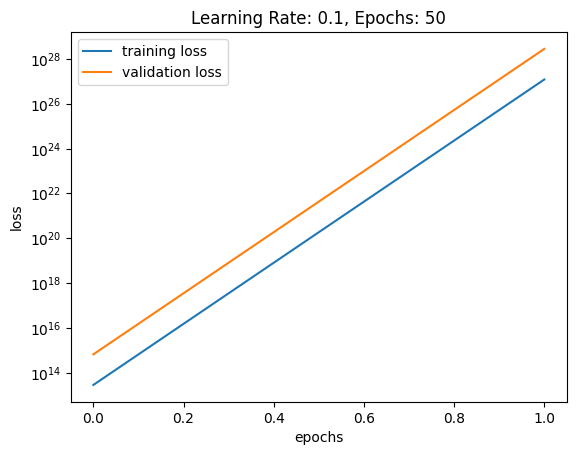

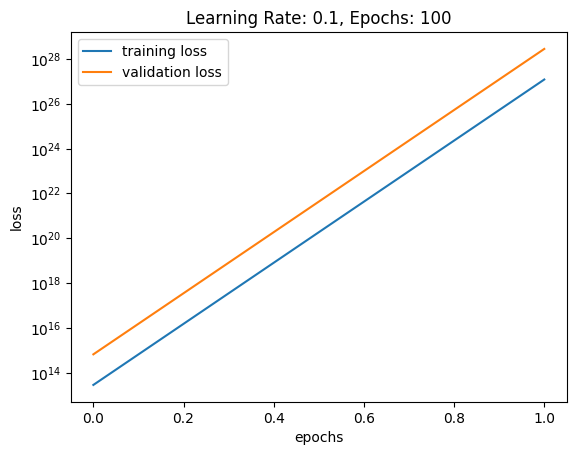

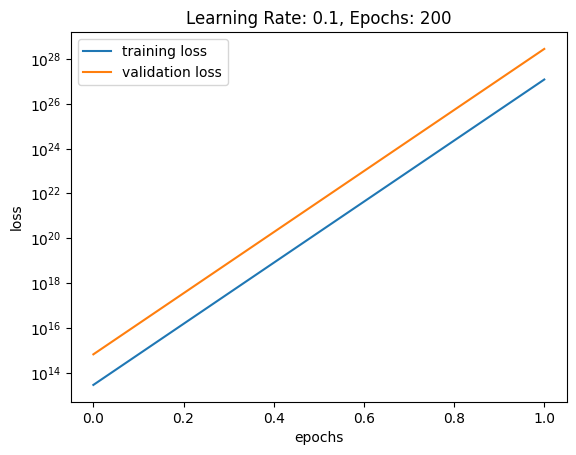

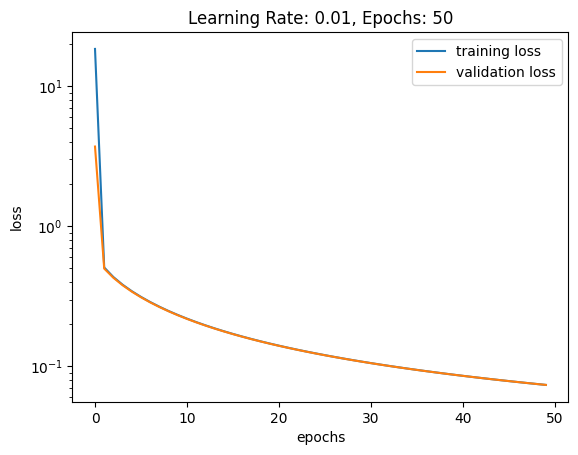

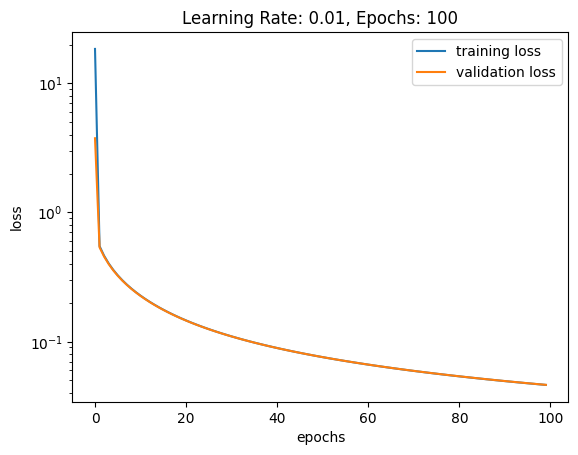

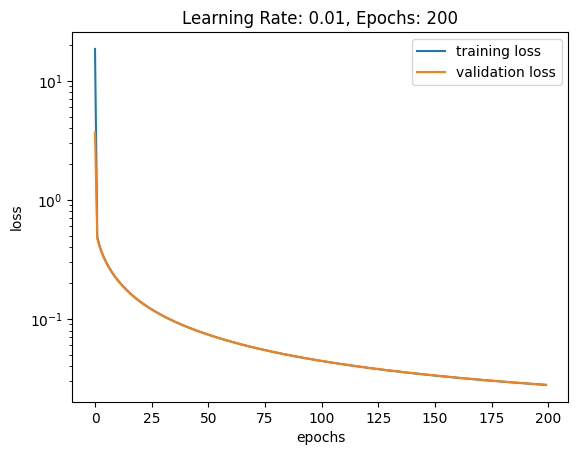

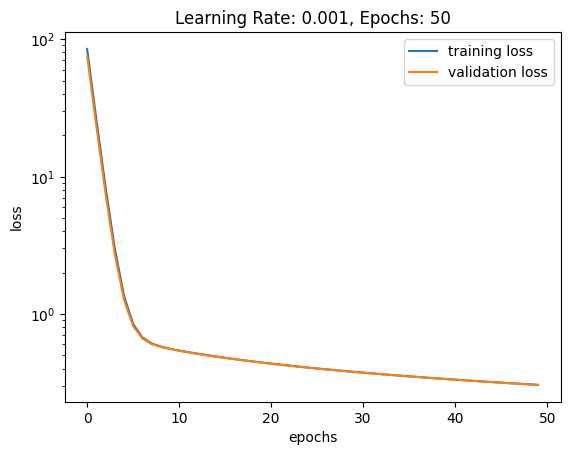

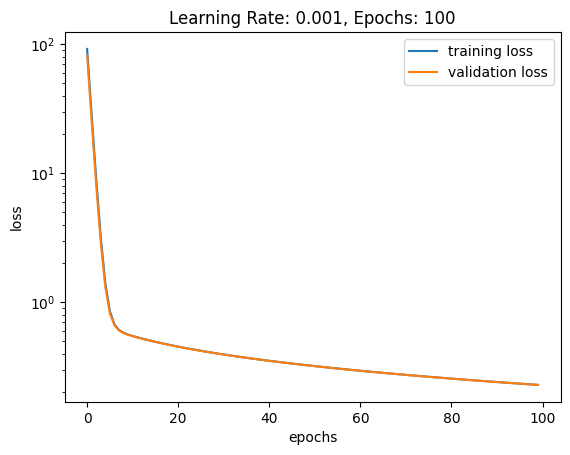

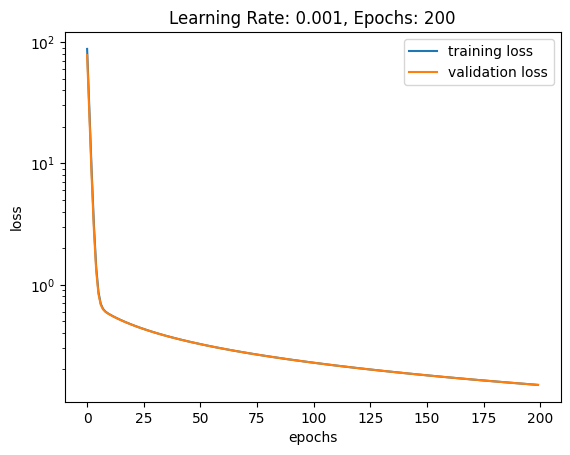

Best Learning Rate: 0.01
Best Epochs: 200


In [ ]:
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

best_loss = float('inf')
best_model = None
best_learning_rate = None
best_epochs = None

learning_rates = [0.1, 0.01, 0.001]
num_epochs = [50, 100, 200]

for lr in learning_rates:
    for num_epoch in num_epochs:
        model = LinearRegression(input_dim, output_dim)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        train_loss_epochs = []
        val_loss_epochs = []

        for epoch in range(num_epoch):
            train_loss = []
            val_loss = []

            for train_index, val_index in kf.split(X_train, y_train):
                model.train()
                inputs = Variable(X_train[train_index])
                labels = Variable(y_train[train_index])

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())

                model.eval()
                with torch.no_grad():
                    inputs_val = Variable(X_train[val_index])
                    labels_val = Variable(y_train[val_index])
                    outputs_val = model(inputs_val)
                    loss_val = criterion(outputs_val, labels_val)
                    val_loss.append(loss_val.item())

            train_loss_epochs.append(sum(train_loss) / len(train_loss))
            val_loss_epochs.append(sum(val_loss) / len(val_loss))

        if val_loss_epochs[-1] < best_loss:
            best_loss = val_loss_epochs[-1]
            best_model = model
            best_learning_rate = lr
            best_epochs = num_epoch

        plt.figure()
        plt.plot(range(num_epoch), train_loss_epochs, label="training loss")
        plt.plot(range(num_epoch), val_loss_epochs, label="validation loss")
        plt.legend(loc="best")
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.yscale("log")
        plt.title("Learning Rate: " + str(lr) + ", Epochs: " + str(num_epoch))
        plt.show()

print("Best Learning Rate:", best_learning_rate)
print("Best Epochs:", best_epochs)


In [ ]:
model = best_model
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_learning_rate)

for epoch in range(best_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

In [ ]:
y_train_pred = torch.exp(model(X_train))
train_rmse = np.sqrt(mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy()))
print("Train RMSE:", train_rmse)

Train RMSE: 196607.03


In [ ]:
predicted_saleprice = torch.exp(model(X_test))

submission = pd.DataFrame({'Id': test['Id'],
                           'SalePrice': predicted_saleprice.detach().numpy().reshape(-1)})
submission.to_csv('submission.csv', index=False)

NETWORK ARCHITECTURE


 i have chosen to go with linear regression model because a CNN or MLP are usually used for more complex tasks but in this assignment i feel linear regression is better as it assumes a linear relationship between the input fetures and the target variables..in this case sale price.
It has  asingle linear layer that takes the input features and produces a single output.

HYPERPARAMETERS


i have used the following hyperparameters:

1) Learning rate: it determines the step size at each iteration of the optimization algorithm.

2)Number of Epochs: this defines the nuber of times the entire training dataset is passed through the model during training.

3)Number of Folds: because K-fold cross validation is used here to access the models performance . this decides the number of fold the training data will be devided into

4)Number of Nueroins: this determines the complexity and capacity of the model

this project uses a grid search approach to tune hyperparameters. teh best hyperparameters are selected based on the validation loss.
The learning rates considered in the grid search are 0.1, 0.01, and 0.001, while the number of epochs explored is 50, 100, and 200.


https://drive.google.com/file/d/1y6MAaFqe5oUvLi67KKkRfyxn6nqRUb_a/view?usp=sharing

The kaggle score image( score = 0.20045)